###  Created by Luis Alejandro (alejand@umich.edu)
An simple MLP training using graphs

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.io as sio
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from utils.graphs.core import Param
from utils.graphs.core import DataHolder
from utils.graphs.core import Graph
from utils.graphs.nodes import linear_node
from utils.graphs.nodes import bias_node
from utils.graphs.nodes import sigmoid_node
from utils.graphs.nodes import relu_node
from utils.graphs.nodes import leaky_relu_node
from utils.graphs.nodes import softmax_mce_node

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import time

In [2]:
def display_subset(X,count=9,order='C'):
    indexes = rnd.permutation(X.shape[0])
    m = int(np.ceil(np.sqrt(count)))
    n = int(np.ceil(count/m))
    fig, axes = plt.subplots(n,m)
    fig.set_size_inches(2*n,2*m)
    for i,ax in enumerate(axes.ravel()):
        if i <= count:
            ax.matshow(X[indexes[i],:].reshape(28,28,order=order), cmap=plt.cm.gray)
            ax.set_xticks(())
            ax.set_yticks(())
        else:
            fig.delaxes(ax)

In [3]:
# Loading the data
datafile = sio.loadmat('../../datasets/classification/mnist/emnist-digits.mat')
X1 = datafile['dataset'][0][0]['train'][0][0]['images']
X1 = X1 / 255.
X2 = datafile['dataset'][0][0]['test'][0][0]['images']
X2 = X2 / 255.
y1 = datafile['dataset'][0][0]['train'][0][0]['labels'].ravel()
y2 = datafile['dataset'][0][0]['test'][0][0]['labels'].ravel()
X = np.concatenate((X1,X2))
y = np.concatenate((y1,y2))

In [4]:
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=5000)

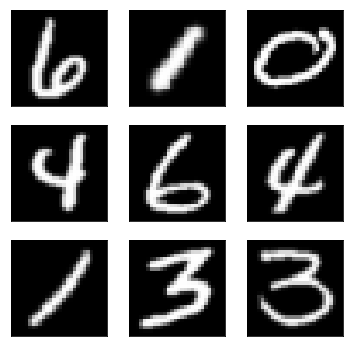

In [5]:
# Displays some examples
display_subset(X_train,order='F')

In [6]:
# Builds models inputs and params
_,d = X_train.shape
n = len(np.unique(y_train))
X_node = DataHolder()
y_node = DataHolder()

In [7]:
# Build hidden layers and all proper connections
hidden_config = [(20,'leaky')] * 2
input_shape = (d,)
input_node = X_node

for config in hidden_config:
    # init weights and bias
    w_node = Param((input_shape[0],config[0]))
    b_node = Param((1,config[0]))
    # builds hidden layer
    r_node = linear_node(input_node,w_node)
    z_node = bias_node(r_node,b_node)
    if config[1] == 'sigmoid':
        h_node = sigmoid_node(z_node)
    elif config[1] == 'relu':
        h_node = relu_node(z_node)
    elif config[1] == 'leaky':
        h_node = leaky_relu_node(z_node)
    else:
        h_node = z_node
    # stores last node to connect to next layer
    input_node = h_node
    input_shape = (config[0],)

w_node = Param((input_shape[0],n))
b_node = Param((1,n))
r_node = linear_node(input_node,w_node)
z_node = bias_node(r_node,b_node)
J_node = softmax_mce_node(z_node,y_node)

In [8]:
# Graph helper object
graph = Graph()
graph.build(J_node).initialize()

In [9]:
# Computing the accuracy of the model with random weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Cost: ', J_node.value)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Cost:  12377.907734727596
Accuracy (Training):  0.10
Accuracy (Test):  0.10


In [10]:
# Training
start = time.perf_counter()
graph.feed({X_node: X_train, y_node: y_train})
niter,history = graph.minimize(optimizer='rmsprop',batch_size=1024,alpha=1e-3)
end = time.perf_counter()
print('In {:} epochs ({:} secs) cost went from {:} to {:}'.format(niter,end-start,history[0],history[-1]))

In 1000 epochs (16.0537159 secs) cost went from 12377.907734727596 to 38.02927676898739


In [11]:
# Computing the accuracy of the model with trained weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Cost: ', J_node.value)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Cost:  38.78689784909879
Accuracy (Training):  1.00
Accuracy (Test):  0.93


In [12]:
# Sklearn implementation
mdl = MLPClassifier(hidden_layer_sizes=(20,20),
                    activation='relu', max_iter=1000, 
                    alpha=0,batch_size=1024,n_iter_no_change=1000)
start = time.perf_counter()
mdl.fit(X_train,y_train)
end = time.perf_counter()
print('Time training: ', end - start, ' sec')
print('# of epochs: ', mdl.n_iter_)
print('Training Metrics:','%.2f' % accuracy_score(y_train,mdl.predict(X_train)))
print('Test Metrics:','%.2f' % accuracy_score(y_test,mdl.predict(X_test)))

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Time training:  34.63367810000001  sec
# of epochs:  1000
Training Metrics: 1.00
Test Metrics: 0.93


#### Notice

Even though the graph implementation is not fully optimized (no computation is done in parallel, among many other possible optimizations not implemented),the time it takes to train the model is smaller than in the sklearn implementation, which is really exciting.